 # DANN for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
import os
import datetime
from copy import deepcopy
from itertools import count
import warnings

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np


import torch
from torch.nn import functional as F
from torch import nn

from src.da_models.dann import DANN
from src.da_models.datasets import SpotDataset
from src.da_models.utils import set_requires_grad
from src.da_models.utils import initialize_weights


# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_6407/677346860.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warnings.warn("Using CPU", stacklevel=2)


In [3]:
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

BATCH_SIZE = 1024
INITIAL_TRAIN_LR = 0.002
NUM_WORKERS = 4
INITIAL_TRAIN_EPOCHS = 100


MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS

PROCESSED_DATA_DIR = "data/preprocessed"

MODEL_NAME = "DANN"


In [4]:
## Adversarial Hyperparameters

EPOCHS = 200
MIN_EPOCHS_ADV = 0.4 * EPOCHS
EARLY_STOP_CRIT_ADV = EPOCHS
ADV_LR = 1e-3

lambd = 10.0
ALPHA = 1.0



In [5]:
model_folder = os.path.join("model", MODEL_NAME, script_start_time)

model_folder = os.path.join("model", MODEL_NAME, "V1")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

 # Data load

In [6]:
# Load spatial data
mat_sp_test_s_d = {}
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_test_s_d.hdf5"), "r") as f:
    for sample_id in f:
        mat_sp_test_s_d[sample_id] = f[sample_id][()]

if TRAIN_USING_ALL_ST_SAMPLES:
    with h5py.File(os.path.join(PROCESSED_DATA_DIR, "mat_sp_train_s.hdf5"), "r") as f:
        mat_sp_train_s = f["all"][()]
else:
    mat_sp_train_s_d = mat_sp_test_s_d

# Load sc data
with h5py.File(os.path.join(PROCESSED_DATA_DIR, "sc.hdf5"), "r") as f:
    sc_mix_train_s = f["X/train"][()]
    sc_mix_val_s = f["X/val"][()]
    sc_mix_test_s = f["X/test"][()]

    lab_mix_train = f["y/train"][()]
    lab_mix_val = f["y/val"][()]
    lab_mix_test = f["y/test"][()]

# Load helper dicts / lists
with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict.pkl"), "rb") as f:
    sc_sub_dict = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "sc_sub_dict2.pkl"), "rb") as f:
    sc_sub_dict2 = pickle.load(f)

with open(os.path.join(PROCESSED_DATA_DIR, "st_sample_id_l.pkl"), "rb") as f:
    st_sample_id_l = pickle.load(f)


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [7]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
source_val_set = SpotDataset(sc_mix_val_s, lab_mix_val)
source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

### target dataloaders
target_test_set_d = {}
for sample_id in st_sample_id_l:
    target_test_set_d[sample_id] = SpotDataset(mat_sp_test_s_d[sample_id])

dataloader_target_test_d = {}
for sample_id in st_sample_id_l:
    dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
        target_test_set_d[sample_id],
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )

if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set = SpotDataset(mat_sp_train_s)
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )
    target_train_set_dis = SpotDataset(deepcopy(mat_sp_train_s))
    dataloader_target_train_dis = torch.utils.data.DataLoader(
        target_train_set_dis,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )
else:
    target_train_set_d = {}
    dataloader_target_train_d = {}

    target_train_set_dis_d = {}
    dataloader_target_train_dis_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_test_s_d[sample_id])
        )
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_train_set_dis_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_test_s_d[sample_id])
        )
        dataloader_target_train_dis_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_dis_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )


 ## Define Model

In [8]:
model = DANN(
    sc_mix_train_s.shape[1], emb_dim=64, ncls_source=lab_mix_train.shape[1], lambd=lambd
)
model.apply(initialize_weights)
model.to(device)


DANN(
  (encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=367, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): ELU(alpha=1.0)
    )
  )
  (dis): AddaDiscriminator(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=512, out_features=1024, bias=True)


 ## Pretrain

In [9]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [10]:
pre_optimizer = torch.optim.AdamW(
    model.parameters(), lr=INITIAL_TRAIN_LR, betas=(0.9, 0.999), eps=1e-07
)

pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    pre_optimizer,
    max_lr=INITIAL_TRAIN_LR,
    steps_per_epoch=len(dataloader_source_train),
    epochs=INITIAL_TRAIN_EPOCHS,
)

criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [11]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred, _ = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(dataloader):

            loss = model_loss(*batch, model)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(batch))

    return np.average(loss_running, weights=mean_weights)


In [12]:
model.pretraining()


In [13]:
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0


# Train
print("Start pretrain...")
outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)

checkpoint = {
    "epoch": -1,
    "model": model,
    "optimizer": pre_optimizer,
    "scheduler": pre_scheduler,
    # 'scaler': scaler
}
for epoch in range(INITIAL_TRAIN_EPOCHS):
    checkpoint["epoch"] = epoch

    # Train mode
    model.train()
    loss_running = []
    mean_weights = []

    inner.refresh()  # force print final state
    inner.reset()  # reuse bar
    for _, batch in enumerate(dataloader_source_train):
        # lr_history_running.append(scheduler.get_last_lr())

        pre_optimizer.zero_grad()
        loss = model_loss(*batch, model)
        loss_running.append(loss.item())
        mean_weights.append(len(batch))  # we will weight average by batch size later

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        pre_optimizer.step()
        pre_scheduler.step()

        inner.update(1)

    loss_history.append(np.average(loss_running, weights=mean_weights))
    loss_history_running.append(loss_running)

    # Evaluate mode
    model.eval()
    with torch.no_grad():
        curr_loss_val = compute_acc(dataloader_source_val, model)
        loss_history_val.append(curr_loss_val)

    # Print the results
    outer.update(1)
    print(
        "epoch:",
        epoch,
        "train loss:",
        round(loss_history[-1], 6),
        "validation loss:",
        round(loss_history_val[-1], 6),
        # "next_lr:", scheduler.get_last_lr(),
        end=" ",
    )
    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
        early_stop_count = 0

        print("<-- new best val loss")
    else:
        print("")

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
        torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

    # check to see if validation loss has plateau'd
    if early_stop_count >= EARLY_STOP_CRIT and epoch >= MIN_EPOCHS - 1:
        print(f"Validation loss plateaued after {early_stop_count} at epoch {epoch}")
        torch.save(checkpoint, os.path.join(pretrain_folder, f"earlystop{epoch}.pth"))
        break

    early_stop_count += 1


# Save final model
best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
torch.save(best_checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 train loss: 2.639954 validation loss: 1.637504 <-- new best val loss
epoch: 1 train loss: 2.03238 validation loss: 1.298942 <-- new best val loss
epoch: 2 train loss: 1.731541 validation loss: 1.154442 <-- new best val loss
epoch: 3 train loss: 1.537449 validation loss: 1.027985 <-- new best val loss
epoch: 4 train loss: 1.381857 validation loss: 0.965309 <-- new best val loss
epoch: 5 train loss: 1.264843 validation loss: 0.91091 <-- new best val loss
epoch: 6 train loss: 1.168745 validation loss: 0.857278 <-- new best val loss
epoch: 7 train loss: 1.088948 validation loss: 0.825381 <-- new best val loss
epoch: 8 train loss: 1.027053 validation loss: 0.800239 <-- new best val loss
epoch: 9 train loss: 0.97642 validation loss: 0.776058 <-- new best val loss
epoch: 10 train loss: 0.930934 validation loss: 0.758764 <-- new best val loss
epoch: 11 train loss: 0.896658 validation loss: 0.739577 <-- new best val loss
epoch: 12 train loss: 0.863504 validation loss: 0.71891 <-- new b

 ## Adversarial Adaptation

In [14]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [15]:
criterion_dis = nn.BCEWithLogitsLoss()


In [16]:
def model_adv_loss(x_source, x_target, y_source, model):
    y_dis_source = torch.zeros(
        x_source.shape[0], device=device, dtype=x_source.dtype
    ).view(-1, 1)
    y_clf, y_dis_source_pred = model(x_source, clf=True)
    loss_clf = criterion_clf(y_clf, y_source)
    loss_dis_source = criterion_dis(y_dis_source_pred, y_dis_source)

    y_dis_target = torch.ones(
        x_target.shape[0], device=device, dtype=x_target.dtype
    ).view(-1, 1)
    _, y_dis_target_pred = model(x_target, clf=False)
    loss_dis_target = criterion_dis(y_dis_target_pred, y_dis_target)

    accu_source = torch.mean(
        (
            torch.round(y_dis_source_pred.detach()).to(torch.long)
            == y_dis_source.detach()
        ).to(torch.float32)
    ).cpu()

    accu_target = torch.mean(
        (
            torch.round(y_dis_target_pred.detach()).to(torch.long)
            == y_dis_target.detach()
        ).to(torch.float32)
    ).cpu()

    return (loss_dis_source, loss_dis_target, loss_clf), (accu_source, accu_target)


def run_epoch(
    dataloader_source, dataloader_target, model, optimizer=None, tqdm_bar=None
):
    source_results = {}
    target_results = {}

    source_results["clf_loss"] = []
    source_results["dis_loss"] = []
    source_results["dis_accu"] = []
    source_results["weights"] = []

    target_results["dis_loss"] = []
    target_results["dis_accu"] = []
    target_results["weights"] = []

    n_iters = max(len(dataloader_source), len(dataloader_target))

    s_iter = iter(dataloader_source)
    t_iter = iter(dataloader_target)
    for i in range(n_iters):
        try:
            x_source, y_source = next(s_iter)
        except StopIteration:
            s_iter = iter(dataloader_source)
            x_source, y_source = next(s_iter)
        try:
            x_target, _ = next(t_iter)
        except StopIteration:
            t_iter = iter(dataloader_target)
            x_target, _ = next(t_iter)

        if optimizer is not None:
            optimizer.zero_grad()

        x_source = x_source.to(torch.float32).to(device)
        x_target = x_target.to(torch.float32).to(device)
        y_source = y_source.to(torch.float32).to(device)

        (loss_dis_source, loss_dis_target, loss_clf), (
            accu_source,
            accu_target,
        ) = model_adv_loss(x_source, x_target, y_source, model)

        source_results["dis_loss"].append(loss_dis_source.item())
        target_results["dis_loss"].append(loss_dis_target.item())
        source_results["clf_loss"].append(loss_clf.item())

        source_results["dis_accu"].append(accu_source)
        target_results["dis_accu"].append(accu_target)

        source_results["weights"].append(len(x_source))
        target_results["weights"].append(len(x_target))

        if optimizer is not None:
            loss = loss_clf + ALPHA*(loss_dis_source + loss_dis_target)
            loss.backward()
            optimizer.step()
        if tqdm_bar is not None:
            tqdm_bar.update(1)

    return source_results, target_results


In [17]:
def train_adversarial_iters(
    model,
    save_folder,
    dataloader_source_train,
    dataloader_source_val,
    dataloader_target_train,
):
    model.to(device)
    model.advtraining()

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=ADV_LR, betas=(0.9, 0.999), eps=1e-07
    )

    max_len_dataloader = max(len(dataloader_source_train), len(dataloader_target_train))

    iters_val = max(len(dataloader_source_val), len(dataloader_target_train))

    # Initialize lists to store loss and accuracy values
    results_running_history_source = {}
    results_running_history_source["clf_loss"] = []
    results_running_history_source["dis_loss"] = []
    results_running_history_source["dis_accu"] = []

    results_running_history_target = {}
    results_running_history_target["dis_loss"] = []
    results_running_history_target["dis_accu"] = []

    results_history_source = {}
    results_history_source["clf_loss"] = []
    results_history_source["dis_loss"] = []
    results_history_source["dis_accu"] = []

    results_history_target = {}
    results_history_target["dis_loss"] = []
    results_history_target["dis_accu"] = []

    results_history_source_val = {}
    results_history_source_val["clf_loss"] = []
    results_history_source_val["dis_loss"] = []
    results_history_source_val["dis_accu"] = []

    results_history_target_val = {}
    results_history_target_val["dis_loss"] = []
    results_history_target_val["dis_accu"] = []

    early_stop_count = 0
    # Train
    print("Start adversarial training...")
    outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
    inner = tqdm(total=max_len_dataloader, desc=f"Batch", position=1)
    print(" Epoch ||| Predictor       ||| Discriminator ")
    print(
        "       ||| Loss            ||| Loss                              || Accuracy      "
    )
    print(
        "       ||| Source          ||| Source          | Target          || Source          | Target          "
    )
    print(
        "       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   "
    )
    print(
        "------------------------------------------------------------------------------------------------------"
    )
    checkpoint = {
        "epoch": -1,
        "model": model,
        "optimizer": optimizer,
    }
    for epoch in range(EPOCHS):
        checkpoint["epoch"] = epoch

        # Train mode
        model.train()
        inner.refresh()  # force print final state
        inner.reset()  # reuse bar

        source_results, target_results = run_epoch(
            dataloader_source_train,
            dataloader_target_train,
            model,
            optimizer=optimizer,
            tqdm_bar=inner,
        )

        for k in results_running_history_source:
            results_running_history_source[k].append(source_results[k])
        for k in results_running_history_target:
            results_running_history_target[k].append(target_results[k])

        for k in results_history_source:
            results_history_source[k].append(
                np.average(source_results[k], weights=source_results["weights"])
            )
        for k in results_history_target:
            results_history_target[k].append(
                np.average(target_results[k], weights=target_results["weights"])
            )

        model.eval()
        with torch.no_grad():
            source_results_val, target_results_val = run_epoch(
                dataloader_source_val, dataloader_target_train, model
            )

        for k in results_history_source:
            results_history_source_val[k].append(
                np.average(source_results_val[k], weights=source_results_val["weights"])
            )
        for k in results_history_target:
            results_history_target_val[k].append(
                np.average(target_results_val[k], weights=target_results_val["weights"])
            )

        # Print the results
        outer.update(1)
        print(
            f" {epoch:5d}",
            f"||| {results_history_source['clf_loss'][-1]:6.4f}",
            f"| {results_history_source_val['clf_loss'][-1]:6.4f}",
            f"||| {results_history_source['dis_loss'][-1]:6.4f}",
            f"| {results_history_source_val['dis_loss'][-1]:6.4f}",
            f"| {results_history_target['dis_loss'][-1]:6.4f}",
            f"| {results_history_target_val['dis_loss'][-1]:6.4f}",
            f"|| {results_history_source['dis_accu'][-1]:6.4f}",
            f"| {results_history_source_val['dis_accu'][-1]:6.4f}",
            f"| {results_history_target['dis_accu'][-1]:6.4f}",
            f"| {results_history_target_val['dis_accu'][-1]:6.4f}",
            end=" ",
        )

        # # Save the best weights
        # if diff_from_rand < best_loss_val:
        #     best_loss_val = diff_from_rand
        #     torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
        #     early_stop_count = 0

        #     print("<-- new best difference from random loss")
        # else:
        #     print("")

        print("")

        # Save checkpoint every 10
        if epoch % 10 == 0 or epoch >= EPOCHS - 1:
            torch.save(checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth"))

        # check to see if validation loss has plateau'd
        # if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV - 1:
        #     print(
        #         f"Loss plateaued after {early_stop_count} at epoch {epoch}"
        #     )
        #     torch.save(checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth"))
        #     break

        early_stop_count += 1

    # Save final model
    torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))

    return (
        results_running_history_source,
        results_running_history_target,
        results_history_source,
        results_history_target,
        results_history_source_val,
        results_history_target_val,
    )


In [18]:
st_sample_id_l = [SAMPLE_ID_N]


Adversarial training for ST slide 151673: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

 Epoch ||| Predictor       ||| Discriminator 
       ||| Loss            ||| Loss                              || Accuracy      
       ||| Source          ||| Source          | Target          || Source          | Target          
       ||| Train  | Val.   ||| Train  | Val.   | Train  | Val.   || Train  | Val.   | Train  | Val.   
------------------------------------------------------------------------------------------------------
     0 ||| 0.4545 | 1.9785 ||| 0.8500 | 0.1910 | 0.8311 | 0.7744 || 0.3451 | 0.0792 | 0.2385 | 0.0041 
     1 ||| 0.4484 | 1.9034 ||| 0.7690 | 0.2403 | 0.8086 | 0.7979 || 0.4061 | 0.1328 | 0.2296 | 0.0008 
     2 ||| 0.4448 | 2.0221 ||| 0.7621 | 0.1920 | 0.7700 | 0.7194 || 0.4518 | 0.0789 | 0.2360 | 0.0099 
     3 ||| 0.4415 | 2.0494 ||| 0.7446 | 0.2147 | 0.7448 | 0.7278 || 0.5115 | 0.0724 | 0.2237 | 0.0036 
     4 ||| 0.4407 | 2.1197 ||| 0.7311 | 0.2724 | 0.7412 | 0.6884 || 0.5792 | 0.1138 | 0.1992 | 0.0033 
     5 ||| 0.4377 | 2.1235 ||| 0.7192 | 0.3026 

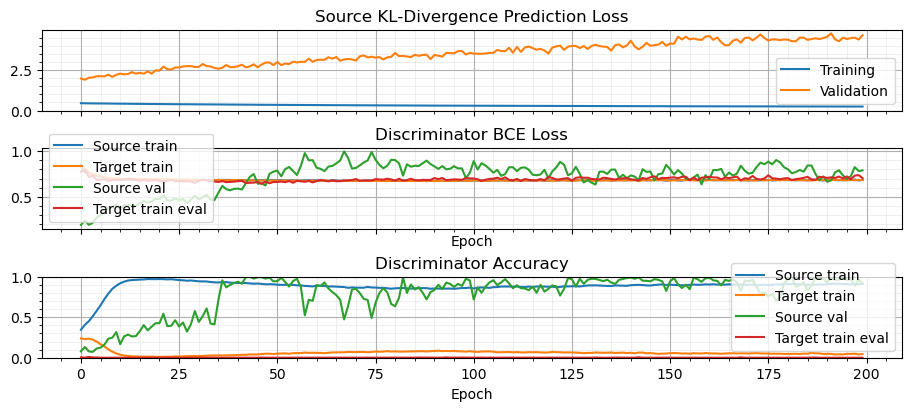

In [19]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    best_pre_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
    model = best_pre_checkpoint["model"]
    model = DANN(
        sc_mix_train_s.shape[1],
        emb_dim=64,
        ncls_source=lab_mix_train.shape[1],
        lambd=lambd,
    )
    model.apply(initialize_weights)
    model.load_state_dict(best_pre_checkpoint["model"].state_dict())
    model.to(device)

    model.advtraining()

    train_adversarial_iters(
        model,
        save_folder,
        dataloader_source_train,
        dataloader_source_val,
        dataloader_target_train,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        best_pre_checkpoint = torch.load(
            os.path.join(pretrain_folder, f"final_model.pth")
        )

        model = best_pre_checkpoint["model"]

        model = DANN(
            sc_mix_train_s.shape[1],
            emb_dim=64,
            ncls_source=lab_mix_train.shape[1],
            lambd=lambd,
        )
        model.apply(initialize_weights)
        model.load_state_dict(best_pre_checkpoint["model"].state_dict())
        model.to(device)

        model.advtraining()

        (
            _,
            _,
            results_history_source,
            results_history_target,
            results_history_source_val,
            results_history_target_val,
        ) = train_adversarial_iters(
            model,
            save_folder,
            dataloader_source_train,
            dataloader_source_val,
            dataloader_target_train_d[sample_id],
        )

        # best_checkpoint = torch.load(os.path.join(save_folder, f"final_model.pth"))
        # best_loss_val = loss_history_val[best_epoch]
        # best_acc_val = accu_history_val[best_epoch]

        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9, 4), layout="constrained")

        # prediction loss
        axs[0].plot(results_history_source["clf_loss"], label="Training")
        axs[0].plot(results_history_source_val["clf_loss"], label="Validation")

        axs[0].set_ylim(bottom=0)
        axs[0].grid(which="major")
        axs[0].minorticks_on()
        axs[0].grid(which="minor", alpha=0.2)

        axs[0].set_title("Source KL-Divergence Prediction Loss")
        axs[0].legend()

        # discriminator loss
        axs[1].plot(results_history_source["dis_loss"], label="Source train")
        axs[1].plot(results_history_target["dis_loss"], label="Target train")
        axs[1].plot(results_history_source_val["dis_loss"], label="Source val")
        axs[1].plot(results_history_target_val["dis_loss"], label="Target train eval")

        axs[0].set_ylim(bottom=0)
        axs[1].grid(which="major")
        axs[1].minorticks_on()
        axs[1].grid(which="minor", alpha=0.2)

        axs[1].set_xlabel("Epoch")
        axs[1].set_title("Discriminator BCE Loss")
        axs[1].legend()

        # discriminator accuracy
        axs[2].plot(results_history_source["dis_accu"], label="Source train")
        axs[2].plot(results_history_target["dis_accu"], label="Target train")
        axs[2].plot(results_history_source_val["dis_accu"], label="Source val")
        axs[2].plot(results_history_target_val["dis_accu"], label="Target train eval")

        axs[2].set_ylim([0, 1])
        axs[2].grid(which="major")
        axs[2].minorticks_on()
        axs[2].grid(which="minor", alpha=0.2)

        axs[2].set_xlabel("Epoch")
        axs[2].set_title("Discriminator Accuracy")
        axs[2].legend()

        plt.show(block=False)
